# TP1 

## Question 1  
### SOLVED ###
La densité électronique, $n_e$, d'un milieu peut être calculée, selon la formule suivante: $$n_e=\frac{N_{A}\cdot Z \cdot \rho}{M},$$ où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $M$ est la masse molaire du milieu ($M = A \cdot M_u$), $A$ est la masse atomique relative et $M_{u}$ la constante de masse molaire ($M_{u} = 1 g/cm^3$). 

Les propriétés des [milieux](https://www.physics.nist.gov/cgi-bin/Star/compos.pl?ap) et des [éléments](https://www.ptable.com) les composants sont obtenues à l'aide du site du NSIT et du site Ptable respectivement.

In [35]:
# Propriétés des milieux (eau et os) sous forme de dictionnaire 

import numpy as np

                        # Densité [g/cm^3]
eau_liq = {"Densité" : 1.00000E+00,
                       # Mean Excitation Energy [MeV]
           "MEE" : 75.000000E-06,
                               # numéro atomique
           "Composition" : np.array([[1, 8], 
                                     # proportion dans le milieu
                                     [0.111894, 0.888106], 
                                     # masse molaire [g/mol] (source ptable.com)
                                     [1.008, 15.999]])} 



                        # Densité [g/cm^3]
os_compact = {"Densité" : 1.85000E+00, 
                      # Mean Excitation Energy [MeV]
              "MEE" : 91.900000E-06,
                                              # numéro atomique
              "Composition" : np.array([[1, 6, 7, 8, 12, 15, 16, 20], 
                                                # proportion dans le milieu
                                        [0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000],
                                                        # masse molaire [g/mol] (source ptable.com)
                                        [1.008, 12.011, 14.007, 15.999, 24.305, 30.738, 32.065, 40.078]])} 


In [36]:
# fonction de la densité électronique selon les propriétés du milieu

import scipy.constants as cst

def n_e(num_ato, proportion, mass_mol, densité):
    return cst.Avogadro * densité * np.sum(proportion * num_ato / mass_mol) 

In [37]:
# n_e pour l'eau et un os compact

eau_liq["n_e"] = n_e(num_ato = eau_liq["Composition"][0], proportion = eau_liq["Composition"][1], 
                     mass_mol = eau_liq["Composition"][2], densité = eau_liq["Densité"])

os_compact["n_e"] = n_e(num_ato = os_compact["Composition"][0], proportion = os_compact["Composition"][1], 
                        mass_mol = os_compact["Composition"][2], densité = os_compact["Densité"])

print("Valeur de la densité électronique selon la formule de Bethe \n   Eau liquide : {:.2E} [électrons/cm^3]\n   Os compact : {:.2E} [électrons/cm^3]".format(eau_liq["n_e"], os_compact["n_e"]))

Valeur de la densité électronique selon la formule de Bethe 
   Eau liquide : 3.34E+23 [électrons/cm^3]
   Os compact : 5.91E+23 [électrons/cm^3]


Comme l'application de la protonthérapie produit des faisceaux de particules dans la gamme 70-250 MeV, soit des protons de plus de 3 MeV, il est possible d'obtenir le pouvoir d'arrêt collisionnel selon l'énergie d'un proton comme suit : 

$$S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2}\left[\ln\left(\frac{2m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right],$$


où $r_e$ est le rayon d'un électron classique, $m_e$ est la masse d'un électron, $c$ est la vitesse de la lumière, $T_e^{max}$ est l'énergie maximale transférable à un électron par le proton, $I$ est l'énergie moyenne d'excitation du matériau et $\beta$ et $\gamma$ sont les facteurs de Lorentz.

In [38]:
# Constantes des protons et électrons

from numpy import sqrt, pi, log

# rayon classique d'un électron [m]
r_e = 2.8179403227E-13     

# énergie de masse d'un électron/c^2 [MeV/(m/s)^2]
m_e_c2 = 0.51099895000

# énergie de masse d'un proton/c^2 [MeV/(m/s)^2]
m_p_c2 = 938.27208816  


# facteur de Lorentz selon l'énergie du proton

def gamma(T):
    return (T/(m_p_c2)) + 1

def beta(T):
    beta = sqrt((gamma(T)**2 - 1) / gamma(T)**2)
    return beta

# Décomposition de Te_max comme les équations (6) de la page 4 de l'énoncé

a = 2 * m_e_c2
b = 1 + (m_e_c2 / m_p_c2)**2
d = 2*(m_e_c2 / m_p_c2)


def Te_max(T):
    return a*(gamma(T)**2 - 1) / (b + d * gamma(T))

In [39]:
# fonction de l'arrêt collisionnel massive pour un proton de plus de 3 MeV
# Pour faciliter la lecture, l'équation Scol est décomposée en variable t1 et t2


def t1(T):
    return 2 * pi * r_e**2 *m_e_c2 / (beta(T)**2)
def t2(T):
    return 2 * m_e_c2 * beta(T)**2 * gamma(T)**2

# Scol varie selon le milieu (eau ou os), en n_e et I. Il varie aussi selon l'énergie du proton T

def Scol(n_e, T, I):
    return t1(T) * n_e * (log(t2(T)*Te_max(T) / I**2) - 2*beta(T)**2)


In [40]:
# valeurs théorique de l'eau

data_water_NSIT = loadtxt("Scol_water_NSIT.txt",float)
data_water_NSIT_x = data_water_NSIT[:,0]
data_water_NSIT_y = data_water_NSIT[:,1]

# valeurs théorique de l'os compact

data_bone_NSIT = loadtxt("Scol_bone_NSIT.txt",float)
data_bone_NSIT_x = data_bone_NSIT[:,0]
data_bone_NSIT_y = data_bone_NSIT[:,1]


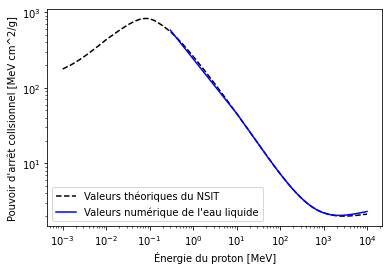

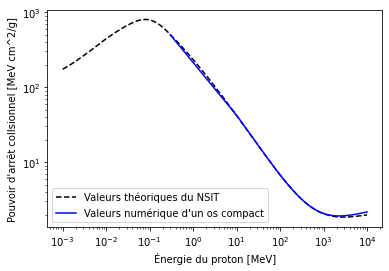

In [41]:
# Présentation des courbes

from numpy import linspace, loadtxt
from math import exp
import matplotlib.pylab as plt

##### eau liquide #####
 

xpoints_w = linspace(0.3, 10000, 1000)
ypoints_w = []

#Les propriétés sont reprises dans les dictionnaires du premier block.
# les valeurs de la fonction Scol() sont divisées par la densité pour obtenir le pouvoir d'arrêt collisionnel

for T in xpoints_w:
    ypoints_w.append(Scol(eau_liq["n_e"], T, eau_liq["MEE"]) / eau_liq["Densité"])

plt.plot(data_water_NSIT[:,0], data_water_NSIT[:,1], "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_w, ypoints_w,"b", label="Valeurs numérique de l'eau liquide")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collsionnel [MeV cm^2/g]")
plt.legend()
plt.show()


##### os compact ######


xpoints_b = linspace(0.3, 10000, 1000)
ypoints_b = []

for T in xpoints_b:
    ypoints_b.append(Scol(os_compact["n_e"], T, os_compact["MEE"]) / os_compact["Densité"])


plt.plot(data_bone_NSIT[:,0], data_bone_NSIT[:,1], "k--", label="Valeurs théoriques du NSIT")
plt.plot(xpoints_b, ypoints_b,"b", label="Valeurs numérique d'un os compact")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton [MeV]")
plt.ylabel("Pouvoir d'arrêt collsionnel [MeV cm^2/g]")
plt.legend()
plt.show()



# Question 2
### SOLVED ###
L'homogénéité dimensionnelle peut être vérifiée lorsque de deux grandeurs s'expriment dans la même unité. On souhaite vérifier l'homogénéité de $R_{CSDA}$ qui est définie par l'équation suivante: $$R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}}.$$ Sachant que $R_{C S D A}$ représente la porté des protons dans un milieu, elle doit donc être exprimée en unité longueur. On souhaite donc que le côté gauche de l'équation soit réductible à une unité de longueur. L'énergie $T$ est exprimée en $[M L^2 T^{-2}]$, $S_{col}$, en $[M L T^{-2}]$ et finalement, $\rho$, en $[M L^{-3}]$. En remplaçant dans l'équation, on obtient: $$\frac{[M L^2 T^{-2}][M L^{-3}]}{[M L T^{-2}]} = \left[\frac{M}{L^2}\right].$$ Le côté droit de l'équation n'est pas exprimé dans la même unité que le côté gauche, cela réfute l'homogénité dimensionnelle de $R_{CSDA}$.

# Question 3
Le pouvoir d’arrêt total est bien approximé par le pouvoir d’arrêt collisionnel aux énergies de la protonthérapie. En effet, lorsqu'on compare les valeurs du pouvoir d'arrêt total du NSIT avec le pouvoir d'arrêt collisionnel de 70 à 250 MeV sur le graphique de la question 1 on voit rapidement que les deux courbes sont très près l'une de l'autre. De façon un peu plus quantitative il est possible d'utiliser l'erreur quadratique moyenne pour comparer les deux courbes:

In [42]:
#Valeurs de 70-250 MeV des courbes théoriques 
T = np.array(data_water_NSIT_x[71:105])

#Valeurs du pouvoir collisionnel de l'eau du NSIT de 70-250 MeV
Scol_eau_NSIT = np.array(data_water_NSIT_y[71:105])

#Valeurs du pouvoir collisionnel de l'eau calculée  de 70-250 MeV
Scol_eau_calculee = Scol(eau_liq["n_e"], T, eau_liq["MEE"]) / eau_liq["Densité"]

#Valeurs du pouvoir collisionnel de l'os du NSIT de 70-250 MeV
Scol_os_NSIT = np.array(data_bone_NSIT_y[71:105])

#Valeurs du pouvoir collisionnel de l'os calculée de 70-250 MeV
Scol_os_calculee = Scol(os_compact["n_e"], T, os_compact["MEE"]) / os_compact["Densité"]

# Root mean square error 
def rmse(y_1,y_2):
    return np.sqrt(((y_1 - y_2) ** 2).mean())

rmse_val_eau = rmse(Scol_eau_calculee, Scol_eau_NSIT)
rmse_val_os = rmse(Scol_os_calculee, Scol_os_NSIT)

print("L\'erreur quadratique moyenne pour l\'eau est: " + str(rmse_val_eau))
print("L\'erreur quadratique moyenne pour l\'os est: " + str(rmse_val_os))

L'erreur quadratique moyenne pour l'eau est: 0.18963548461816188
L'erreur quadratique moyenne pour l'os est: 0.23719006436818366


Comme on peut le constater l'erreur quadratique moyenne est plutôt faible pour des valeurs allant de 7 à 250. Il est à noter que les valeurs théoriques du NSIT prennent en compte les pouvoir d'arrêt électronnique et nucléaire alors que le pouvoir d'arrêt calculée ne comprend que le pouvoir d'arrêt électronnique. On comprend donc que le pouvoir d'arrêt nucléaire n'a pas énormément d'impact sur le résultat sur cette plage de valeur. En effet, le pouvoir d'arrêt nucléaire est souvent négligeable sauf pour des ions de très faible énergie comme on peut le voir sur le graphique suivant (l'eau a été choisie, car l'effet était plus important que pour l'os):   

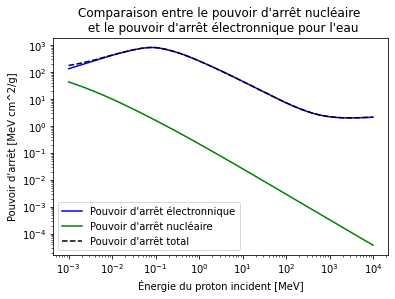

In [43]:
fichier = "All_water_data_NSIT.txt"
data = np.loadtxt(fichier, skiprows = 8)


plt.plot(data[:,0], data[:,1], "b", label="Pouvoir d'arrêt électronnique")
plt.plot(data[:,0], data[:,2],"g", label="Pouvoir d'arrêt nucléaire")
plt.plot(data[:,0], data[:,3],"k--", label="Pouvoir d'arrêt total")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Énergie du proton incident [MeV]")
plt.ylabel("Pouvoir d'arrêt [MeV cm^2/g]")
plt.legend()
plt.title("Comparaison entre le pouvoir d'arrêt nucléaire \n et le pouvoir d'arrêt électronnique pour l'eau")
plt.show()

L'autre pouvoir d'arrêt qui a été négligé est le pouvoir d'arrêt radiatif qui apparait lorsque le rayonnement de freinage du proton doit être considéré. Pour qu'il soit considéré le proton doit avoir une énergie bien plus élevé que dans le cadre de la protonthérapie.

# Question 4
Une raison qui justifie l'emploi de la méthode numérique est le fait que l'intégration de la fonction $1/S_{col}(T)$ ne donne pas une fonction formée de fonctions élémentaires. En effet, lorsqu'on passe l'équation dans une algorithme ayant pour but de vérifier si la solution de l'intégrale est formée de fonctions élementaires, comme l'algorithme de Risch, celui-ci ne donne pas une solution. Il est donc plus simple d'évaluer l'intégrale numériquement.  


# Question 5


Intégration par la méthode des trapèzes et par Simpson

In [ ]:
def trapeze(func,a,b,N):
    #--Calcul d'intégration par méthode des trapèzes

    #--Paramètres:
    #   func: Fonction à intégrer
    #   a,b: Borne inférieure(a) et suppérieure(b) de l'intérale
    #   N: Nombre de tranches

    #--Retourne la solution à l'intégration

    h = abs(b - a) / N  # Largeur des tranches
    x= np.linspace(a,b,N+1) #N+1 points dans l'intervale [a,b]
    y=func(x) #f(x) de ces points
    yr = y[1:] #Borne de droite de chaque tranche
    yl = y[:-1] #Borne de gauche de chaque tranche
    return h*0.5*(np.sum(yl)+np.sum(yr)) #Aire de l'ensemble des segments

def simpson(func,a,b,N):
    #--Calcul d'intégration par méthode de Simpson

    #--Paramètres:
    #   func: Fonction à intégrer
    #   a,b: Borne inférieure(a) et suppérieure(b) de l'intérale
    #   N: Nombre de tranches

    #--Retourne la solution à l'intégration
    
    h = abs(b - a) / N  # Largeur des tranches
    x= np.linspace(a,b,N+1) #N+1 points dans l'intervale [a,b]
    y=func(x) #f(x) de ces points
    yr1 = y[1::2] #Borne de droite des tranche impairs
    yl1 = y[:-1:2] #Borne de gauche des tranches impairs
    s1 = np.sum(yl1)+np.sum(yr1) #Aires des tranches impairs
    yr2 = y[2::2]#Borne de droite des tranche pairs
    yl2 = y[:-2:2]#Borne de droite des tranche pairs
    s2 = np.sum(yl2) + np.sum(yr2)#Aires des tranches pairs
    return h/3*(s1*2+s2) #Aire de l'ensemble des segments

Algorithme d'intégration pour calculer la portée des protons

In [ ]:
def error(func,a,b,N0,precision):
    #--Calcul d'intégrale avec la méthode des trapèzes et son erreur se raprochant 
    #d'une certaine précision

    #--Paramètres:
    #   func: Fonction è intégrer
    #   a,b: Borne inférieure(a) et suppérieure(b) de l'intérale
    #   N0: Nombre initiale de tranches
    #   precision: Précision recherchée

    #--Retourne la solution à l'intégrale avec la méthode des trapèze avec
    #un nombre de tranche maximale permis par la précision recherchée et son erreur.

    #Initialisation des listes de solutions et d'erreurs
    s = []
    err = []
    #Première itération
    i0 = trapeze(func,a,b,N0)
    s.append(i0)
    #Deuxième itération avec 2*N0
    N = 2 * N0
    iN = trapeze(func,a,b,N)
    s.append(iN)
    err.append(abs(iN-i0)/3) #Erreur d'approximation sur l'évaluation avec 2N tranches
    #Itérations pour trouvées Nmax qui est atteint lorsque l'erreur est supérieur à la précision recherchée en doublant le nombre de tranches.
    while err[-1] >= precision:
        i = iN
        N = 2 * N
        iN = trapeze(func,a,b,N)
        s.append(iN)
        err.append(abs((iN - i) / 3))
    return iN,N,err[-1]

# Question 6
Mettre l'équation 